# Project 3 - Tennis
## Payam Mousavi

In [1]:
# Standard Python packages:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Torch:
import torch

# Others
from unityagents import UnityEnvironment
from config import Config
from model import Actor, Critic
from replay import ReplayBuffer
from noise import OUNoise
from agent import DDPGAgent
from multi_agent import MultiAgent

In [3]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Setting up the parameters:
I started with the same parameter values I used for project #2 - Continuous control

In [8]:
config = Config()

config.seed = 42
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)
config.action_size = brain.vector_action_space_size
config.actor_hidden_units = (256, 128)
config.actor_learning_rate = 1e-4
config.actor_network_fn = lambda: Actor(config.action_size, config.state_size, config.actor_hidden_units,
                                        config.seed).to(config.device)

config.actor_optimizer_fn = lambda params: torch.optim.Adam(params,lr=config.actor_learning_rate)

config.critic_hidden_units = (256, 128)
config.critic_learning_rate = 3e-4
config.weight_decay = 0
config.critic_network_fn = lambda: Critic(config.action_size, config.state_size, config.critic_hidden_units,
                                          config.seed).to(config.device)

config.critic_optimizer_fn = lambda params: torch.optim.Adam(params,lr=config.critic_learning_rate)

config.shared_replay_buffer = True
config.batch_size = 256
config.buffer_size = 1000000
config.discount = 0.98
config.update_every = 5
config.memory_fn = lambda: ReplayBuffer(config.action_size, config.buffer_size,
                                        config.batch_size, config.seed, config.device)

config.noise_fn = lambda: OUNoise(config.action_size,config.seed)

## Setting up the algorithm:

In [11]:
agent = MultiAgent(config)


# Function adpated from Udacity DeepRL Github - DDPG_Bipedal walker
def ddpg(n_episodes=10000, max_t=1000):
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            scores += rewards
            states = next_states
        
        # Calculating average scores:
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.50:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

## Training:

In [12]:
s = ddpg()

Episode 100	Average Score: -0.202
Episode 154	Average Score: 0.5055
Environment solved in 54 episodes!	Average Score: 0.51


## Plotting the final results:

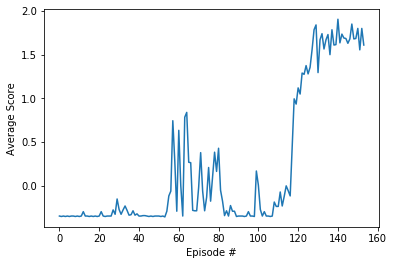

In [14]:
# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(s)), s)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
env.close()